<a href="https://colab.research.google.com/github/VladimirVladetic/RUAPAnimals/blob/main/Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from PIL import Image

#sickit_learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight, shuffle

#keras
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from google.colab import files
import os
import zipfile
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

In [4]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [5]:
! kaggle datasets download -d alessiocorrado99/animals10

100% 583M/586M [00:26<00:00, 26.0MB/s]
100% 586M/586M [00:26<00:00, 23.5MB/s]


In [6]:
with zipfile.ZipFile('/content/animals10.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
## mucca = krava = 0
## ragno = pauk = 1
## scoiattolo = vjeverica = 2
## cavallo = konj = 3
## farfalla = leptir = 4
## elefante = slon = 5
## gallina = kokos = 6
## pecora = ovca = 7
## cane = pas = 8
## gatto = macka = 9

In [2]:
def plot_animals(df):
    plt.figure(figsize=(15, 5))
    df['category_names'] = df['category'].map(animal_mapping)
    sns.countplot(data=df, x='category_names', edgecolor='black')
    plt.title('Animal Distribution')
    plt.xlabel('Animal Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [3]:
def extract_features(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = load_img(image, color_mode='grayscale')
        var_img = var_img.resize((height,width), Image.Resampling.LANCZOS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 1)
    features = np.array(features, dtype=np.float32)
    return features

In [4]:
def display_images(images, num_images=5):
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

In [5]:
def create_model(input_shape,num_classes):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    batch_1 = BatchNormalization()(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(batch_1)
    batch_2 = BatchNormalization()(conv_2)

    maxpool_1 = MaxPooling2D(pool_size=(2,2))(batch_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(dropout_1)
    batch_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(batch_3)
    batch_4 = BatchNormalization()(conv_4)

    maxpool_2 = MaxPooling2D(pool_size=(2,2))(batch_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(dropout_2)
    batch_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same')(batch_5)
    batch_6 = BatchNormalization()(conv_6)

    maxpool_3 = MaxPooling2D(pool_size=(2,2))(batch_6)
    dropout_3 = Dropout(0.25)(maxpool_3)

    conv_7 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(dropout_3)
    batch_7 = BatchNormalization()(conv_7)
    conv_8 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(batch_7)
    batch_8 = BatchNormalization()(conv_8)

    maxpool_4 = MaxPooling2D(pool_size=(2,2))(batch_8)
    dropout_4 = Dropout(0.25)(maxpool_4)

    conv_9 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(dropout_4)
    batch_9 = BatchNormalization()(conv_9)
    conv_10 = Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(batch_9)
    batch_10 = BatchNormalization()(conv_10)

    flatten = Flatten()(batch_10)

    dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)

    dropout_1 = Dropout(0.3)(dense_1)

    dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)

    output = Dense(num_classes, activation='softmax', name="animal_out")(dense_2)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [6]:
foldernames = os.listdir('/content/raw-img/')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/raw-img/" + folder);
    for file in filenames:
        files.append("/content/raw-img/" + folder + "/" + file)
        categories.append(k)

df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [7]:
animal_mapping = {
    0: 'Krava',
    1: 'Pauk',
    2: 'Vjeverica',
    3: 'Konj',
    4: 'Leptir',
    5: 'Slon',
    6: 'Kokos',
    7: 'Ovca',
    8: 'Pas',
    9: 'Macka'
}

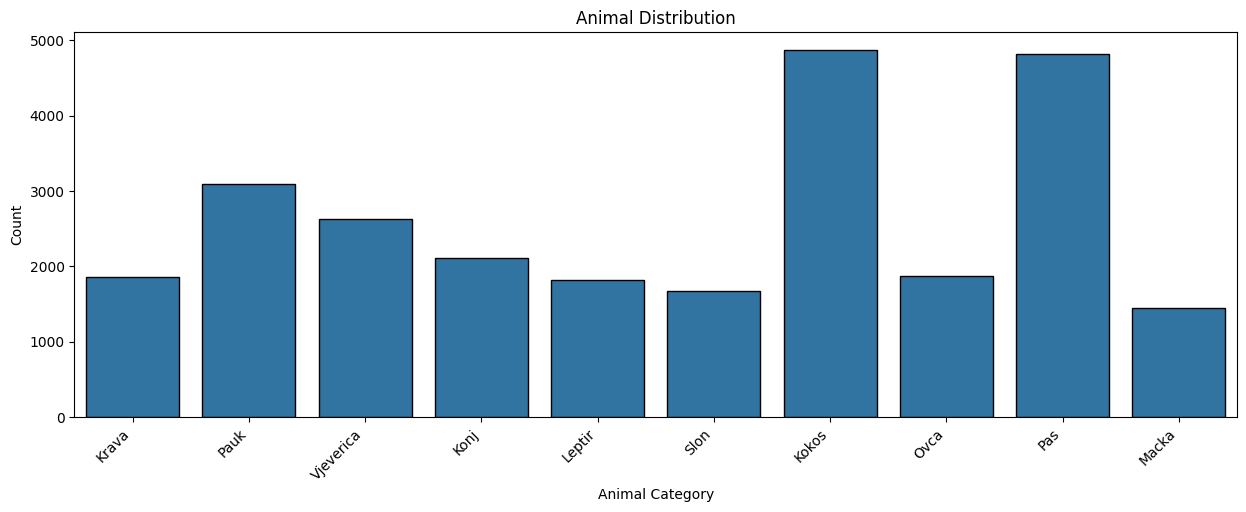

In [10]:
plot_animals(df)

In [8]:
image_height = 128
image_width = 128
num_classes = 10

In [9]:
X = extract_features(df["filename"],image_height,image_width)

y = np.array(df["category"])

y = np.array(list(df["category"].apply(lambda x: to_categorical(x, num_classes=num_classes))))

input_shape = (image_height,image_width,1)

<ipython-input-3-c45749b9876c>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm(images):


  0%|          | 0/26179 [00:00<?, ?it/s]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

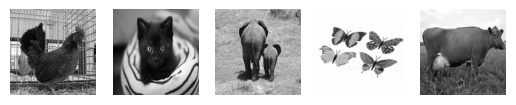

In [11]:
display_images(X_train)

In [12]:
opt = Adam(learning_rate=0.005)

In [13]:
model = create_model(input_shape, num_classes)

model.compile(loss="categorical_crossentropy", optimizer = opt, metrics='accuracy' )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
262/262 [==============================] - 129s 393ms/step - loss: 18.4158 - accuracy: 0.1935 - val_loss: 3.6145 - val_accuracy: 0.1776 - lr: 0.0050
Epoch 2/100
262/262 [==============================] - 87s 333ms/step - loss: 3.2199 - accuracy: 0.2139 - val_loss: 2.9540 - val_accuracy: 0.1895 - lr: 0.0050
Epoch 3/100
262/262 [==============================] - 89s 338ms/step - loss: 2.8260 - accuracy: 0.2137 - val_loss: 2.6734 - val_accuracy: 0.1919 - lr: 0.0050
Epoch 4/100
262/262 [==============================] - 89s 339ms/step - loss: 2.8534 - accuracy: 0.2383 - val_loss: 2.7778 - val_accuracy: 0.1502 - lr: 0.0050
Epoch 5/100
262/262 [==============================] - 89s 339ms/step - loss: 2.8060 - accuracy: 0.2732 - val_loss: 2.8427 - val_accuracy: 0.1762 - lr: 0.0050
Epoch 6/100
262/262 [==============================] - 90s 344ms/step - loss: 2.6393 - accuracy: 0.2805 - val_loss: 2.8539 - val_accuracy: 0.2058 - lr: 0.0050
Epoch 7/100
262/262 [=======================

In [ ]:
model.save('animalmodel.h5')


In [15]:
def display_acc_graph(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Accuracy Graph")
    plt.legend()
    plt.figure()

def display_loss_graph(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.show()

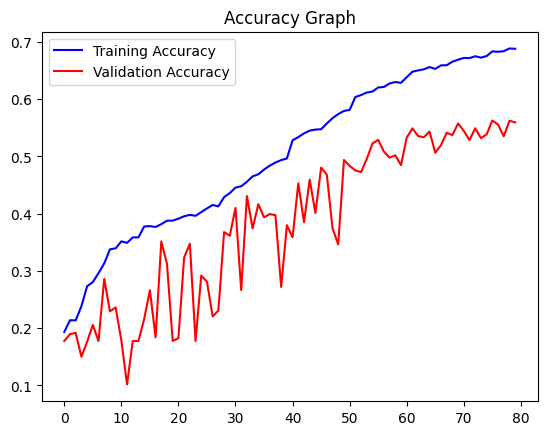

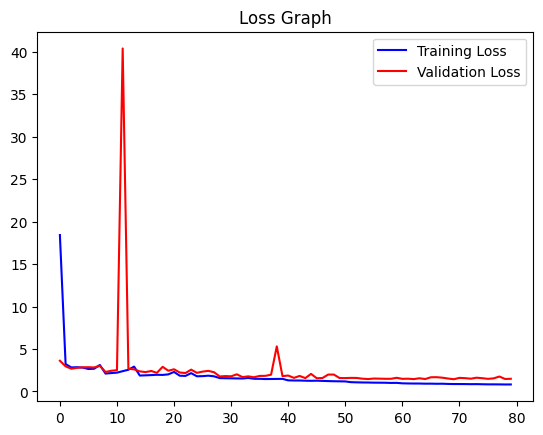

In [16]:
display_acc_graph(history)
display_loss_graph(history)

In [ ]:
#KNN
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train[0],-1)
X_test = X_test.reshape(X_test[0],-1)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make Predictions
y_pred = knn_model.predict(X_test)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix_age = confusion_matrix(y_test, y_pred)
print(conf_matrix_age)

skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(8, 6), cmap='Blues')
plt.xlabel('Predicted Animal')
plt.ylabel('True Animal')
plt.title('Confusion Matrix for Age')
plt.show()

In [ ]:
with open('knn_animal_model.pkl', 'wb') as model_file:
    pickle.dump(knn_model, model_file)

# with open('knn_model.pkl', 'rb') as model_file:
#     knn_model = pickle.load(model_file)

In [ ]:
from google.colab import files
files.download("/content/knn_model.pkl")

In [ ]:
## SVM

import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train)

X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train_flattened, y_train)

y_pred = svm_model.predict(X_test_flattened)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)

# with open('svm_model.pkl', 'rb') as model_file:
#     loaded_svm_model = pickle.load(model_file)

from google.colab import files
files.download("/content/svm_model.pkl")

In [ ]:
## ResNet

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

X_train_paths, X_test_paths, y_train, y_test = train_test_split(X_paths, y_one_hot, test_size=0.2, random_state=42)

def load_and_preprocess_images(file_paths):
    images = []
    for file_path in file_paths:
        img = image.load_img(file_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return images

X_train = load_and_preprocess_images(X_train_paths)
X_test = load_and_preprocess_images(X_test_paths)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x=X_train, y=y_train, epochs=5, validation_data=(X_test, y_test))

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_prob.argmax(axis=1))
y_true = label_encoder.inverse_transform(y_test.argmax(axis=1))

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print a classification report for more detailed metrics
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))